# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the Network and Noise Model

In [3]:
typeNoiseModel='GMM' # Choose 'GMM' or 'histogram' to specify the appropriate noise model
dataName = 'mouseactin'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
mode = 'bootstrap' #  #Either 'bootstrap'(bootstrapping mode) or 'calibration'(using calibration data)
if (typeNoiseModel =='GMM'):
    n_gaussian = 3 # If using GMM noise model, specify number of Gaussians created in CreateNoiseModel_GMM.ipynb
    n_coeff = 2 # If using GMM noise model, specify number of coefficients created in CreateNoiseModel_GMM.ipynb

In [4]:
if(typeNoiseModel=='GMM'): 
    namePN2VModel=dataName+'_GMM_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode
    params= np.load(path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     torch.Tensor(params['trained_weight']))
else:
    namePN2VModel=dataName+'_histogram_'+mode
    histogram = np.load(path+'noiseModelHistogram_'+ dataName+'_'+mode+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [5]:
net=torch.load(path+"/last_"+namePN2VModel+".net")

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR prior 33.467767688502846
PSNR mse 33.73645725311932
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR prior 33.38299540424594
PSNR mse 33.64645675923309
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR prior 33.40687719100121
PSNR mse 33.675822779684886
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR prior 33.4966661763492
PSNR mse 33.76576074882527
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR prior 33.47058025610894
PSNR mse 33.737131176472936
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR prior 33.431812902144
PSNR mse 33.699462980422425
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR prior 33.418843757076395
PSNR mse 33.68813098741954
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR prior 33.47411398779339
PSNR mse 33.738

image: 63
PSNR input 23.720689613627076
PSNR prior 33.41396414482812
PSNR mse 33.69084956213554
-----------------------------------
image: 64
PSNR input 23.716027075591573
PSNR prior 33.44131273771383
PSNR mse 33.72243644365169
-----------------------------------
image: 65
PSNR input 23.73440771063101
PSNR prior 33.48528054920826
PSNR mse 33.75521669519249
-----------------------------------
image: 66
PSNR input 23.752612512661457
PSNR prior 33.28176533245325
PSNR mse 33.5512851417715
-----------------------------------
image: 67
PSNR input 23.76459996947784
PSNR prior 33.43170105822083
PSNR mse 33.70709251678343
-----------------------------------
image: 68
PSNR input 23.759235163477868
PSNR prior 33.40583237548039
PSNR mse 33.68181954936844
-----------------------------------
image: 69
PSNR input 23.745309084966966
PSNR prior 33.473309405644585
PSNR mse 33.739898005979676
-----------------------------------
image: 70
PSNR input 23.7092400215346
PSNR prior 33.36581683736294
PSNR mse 3

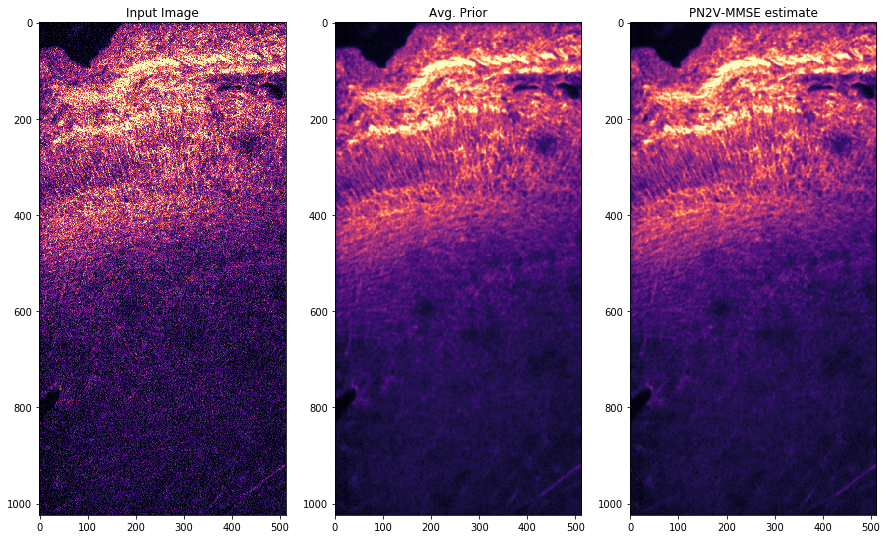

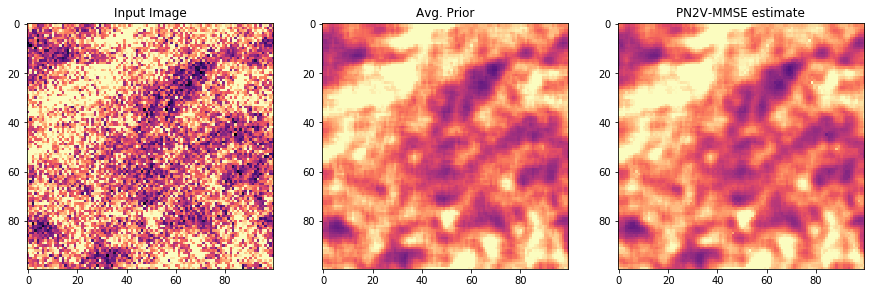

Avg PSNR Prior: 33.44160741798158 +-(2SEM) 0.009069975485142354
Avg PSNR MMSE: 33.713178498290105 +-(2SEM) 0.009335742136426763


In [6]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )